Import Required Libraries


In [1]:
import os
import torch
import torchvision
import tarfile

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

Download Dataset using Download URL

In [2]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

  0%|          | 0/135107811 [00:00<?, ?it/s]

Extract the Files and Save in a directory


In [3]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path='./data')

#Check the directory

data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['horse', 'cat', 'dog', 'bird', 'truck', 'frog', 'ship', 'automobile', 'deer', 'airplane']


Data Preprocessing

In [4]:
#Image to tensor

dataset = ImageFolder(data_dir + '/train', transform= ToTensor())
test_dataset = ImageFolder(data_dir + '/test', transform= ToTensor())
len(dataset), len(test_dataset)

(50000, 10000)

In [5]:
#Check sample data

img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

Label:  airplane (0)


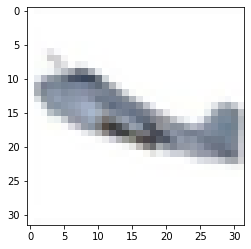

In [6]:
#Visualize the sample data as image

def show_example(img, label):
  print('Label: ', dataset.classes[label], "(" + str(label) + ")")
  plt.imshow(img.permute(1, 2, 0))

show_example(*dataset[1364])

In [7]:
#Train-validation separation

random_seed = 42
torch.manual_seed(random_seed)

val_size = 7500
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(42500, 7500)

In [9]:
#Load data as a batch

batch_size = 128

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle = True, 
                      num_workers = 2,
                      pin_memory = True)
val_dl = DataLoader(val_ds,
                    batch_size * 2,
                    num_workers = 2,
                    pin_memory = True)

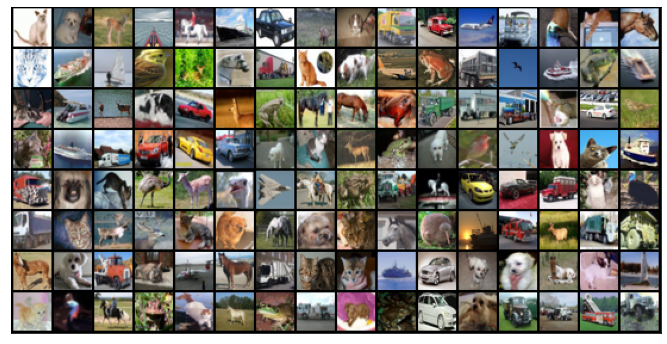

In [10]:
#Visualize a Batch of sample data

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize = (12, 6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow= 16).permute(1, 2, 0))
    break

show_batch(train_dl)

Create Model

In [11]:
#Base Classification

class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)                        #Generate Prediction
    loss = F.cross_entropy(out, labels)       #Calculate Loss
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)                        #Generate Predictions
    loss = F.cross_entropy(out, labels)       #Calculate Loss
    acc = accuracy(out, labels)               #Calculate Accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()     #Mean of Loss in a epoch
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()        #Mean of Accuracy in a epoch
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
          epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [12]:
#Calculate Accuracy

def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim = 1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [25]:
#Cifer 10 CNN Model

class Cifar10CnnModel(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size= 3, padding= 1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size= 3, stride= 1, padding= 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),       #Output:64 X 16 X 16
        
        nn.Conv2d(64, 128, kernel_size= 3, stride= 1, padding= 1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size= 3, stride= 1, padding= 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),           #Output: 128 X 8 X 8

        nn.Conv2d(128, 256, kernel_size= 3, stride= 1, padding= 1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size= 3, stride= 1, padding= 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

        nn.Flatten(), 
        nn.Linear(256*4*4, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
        )
    
  def forward(self, xb):
    return self.network(xb)

In [26]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

Graphics Processing Unit (GPU)

In [18]:
#Primary Operations (GPU Setup)

def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  """Move tensors to chosen device"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """Number of Batches"""
    return len(self.dl)

In [43]:
#Load Data and model in GPU

device = get_default_device()

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

Training Model


In [44]:
@torch.no_grad()

#Evaluation

def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

#Fit Function

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
  hist = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    #Training Phase
    model.train()
    train_losses = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    #Validation Phase
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    hist.append(result)
  return hist

In [45]:
evaluate(model, val_dl)

{'val_acc': 0.7851356267929077, 'val_loss': 1.7126879692077637}

In [46]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

hist = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

KeyboardInterrupt: ignored

Plot Training Progress

In [47]:
#Accuracy Vs Epoch

def plot_accuracies(hist):
  accuracies = [x['val_acc'] for x in hist]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy Vs No. of Epoch')

#Loss Vs Epoch

def plot_losses(hist):
  train_losses = [x.get('train_loss') for x in hist]
  val_losses = [x['val_loss'] for x in hist]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss Vs No. of Epoch');

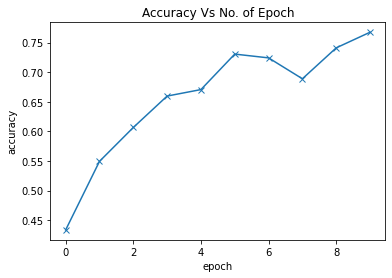

In [34]:
plot_accuracies(hist)

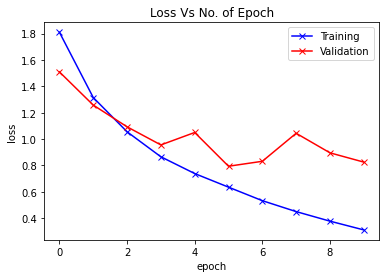

In [48]:
plot_losses(hist)

Test Model

In [49]:
#Predict Individual Image

def predict_image(img, model):
  #Convert to a batch of 1
  xb = to_device(img.unsqueeze(0), device)
  #Get predictions from model
  yb = model(xb)
  #Pick index with highest probability
  _, preds = torch.max(yb, dim = 1)
  #Retrieve the class label
  return dataset.classes[preds[0].item()]

Label:  automobile , Predicted:  automobile


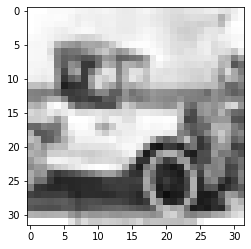

In [51]:
test_dataset = ImageFolder(data_dir + '/test', transform= ToTensor())

img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label: ', dataset.classes[label], ', Predicted: ', predict_image(img, model))

In [52]:
#Testing on test dataset

test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size *2), device)
result = evaluate(model, test_loader)
print("Test Accuracy: ", result['val_acc'], ", Test Loss: ", result['val_loss'])

Test Accuracy:  0.7635742425918579 , Test Loss:  1.1155833005905151


Saving the trained model


In [53]:
torch.save(model.state_dict(), 'cifar-10-CNN.pth')

Use and check saved model

In [54]:
model2 = to_device(Cifar10CnnModel(), device)
model2.load_state_dict(torch.load('cifar-10-CNN.pth'))

<All keys matched successfully>

In [55]:
evaluate(model2, test_loader)

{'val_acc': 0.7635742425918579, 'val_loss': 1.1155833005905151}